# RF

Starting parameter optimization...
Grid size: 540 parameter combinations
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Best parameters: {'max_depth': None, 'max_features': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Cross-validation R² scores: -0.6405 (±1.0944)

OPTIMIZED MODEL PERFORMANCE
----------------------------
TEST SET METRICS:
R^2 Score: 0.8138
RMSE: 54.0202
MAE: 28.9081

TRAINING SET METRICS:
R^2 Score: 0.9634
RMSE: 25.2816
MAE: 12.7088


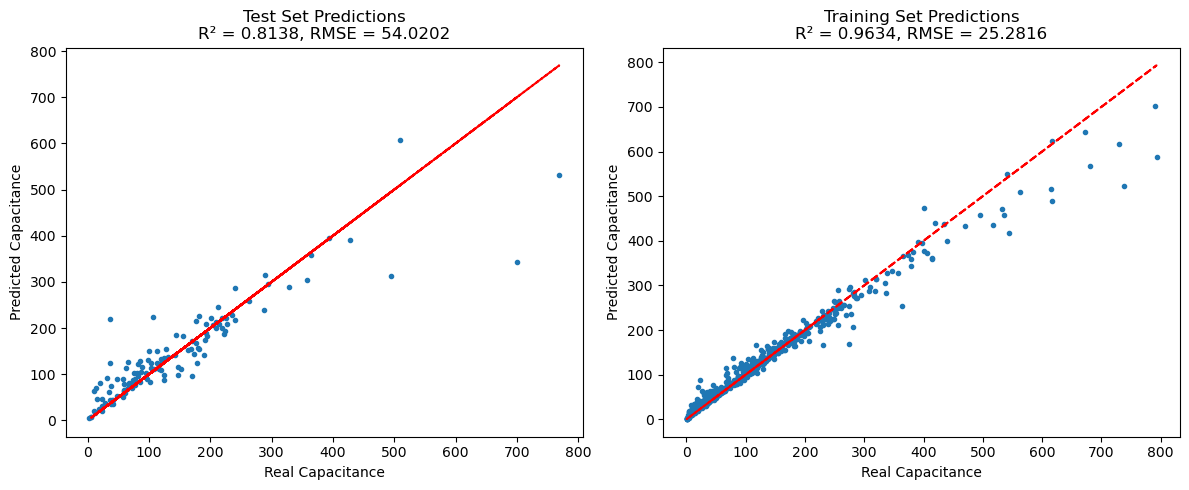

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
import pickle

DatasetI= pd.read_excel ('DatasetI3-PMM.xlsx')

numerical_features = ['onetcontent', 'dspacing', 'SSA', 'AMR', 'BR', 'CR', 'Cationsize', 'Anionsize', 'Molarity', 'PW', 'CD']
categorical_features = ['Config']

x = DatasetI[numerical_features + categorical_features]
y = DatasetI['Capacitance']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=100)

class TrackingRF(RandomForestRegressor):
    def fit(self, X, y, **kwargs):
        self.X_train_ = X
        self.y_train_ = y
        return super().fit(X, y, **kwargs)

def scorer(estimator, X, y):
  
    y_pred = estimator.predict(X)
    test_r2 = metrics.r2_score(y, y_pred)
    
    y_train_pred = estimator.predict(estimator.X_train_)
    train_r2 = metrics.r2_score(estimator.y_train_, y_train_pred)
    
    overfitting_score = abs(train_r2 - test_r2)
    
    alpha = 1.3 
    objective = test_r2 - alpha * overfitting_score
    
    return objective

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5, 0.7, 0.9]      
}
print("Starting parameter optimization...")
print(f"Grid size: {np.prod([len(v) for v in param_grid.values()])} parameter combinations")

# Create GridSearchCV 
grid_search = GridSearchCV(
    TrackingRF(random_state=42, warm_start=True),
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Train the optimized model
optimized_model = RandomForestRegressor(**best_params, random_state=42)

optimized_model.fit(x_train, y_train)

# Cross Validation (10-fold)
cv_scores = cross_val_score(optimized_model, x, y, cv=10)
print(f"Cross-validation R² scores: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Prediction for test set
y_pred = optimized_model.predict(x_test)

# Evaluation metrics for test set
mae_RF = metrics.mean_absolute_error(y_test, y_pred)
mse_RF = metrics.mean_squared_error(y_test, y_pred)
rmse_RF = np.sqrt(mse_RF)  
r2_RF = metrics.r2_score(y_test, y_pred)

# Prediction for training set
y_pred_train = optimized_model.predict(x_train)

# Evaluation metrics for training set
mae_RF_train = metrics.mean_absolute_error(y_train, y_pred_train)
mse_RF_train = metrics.mean_squared_error(y_train, y_pred_train)
rmse_RF_train = np.sqrt(mse_RF_train)  
r2_RF_train = metrics.r2_score(y_train, y_pred_train)

r2_diff = abs(r2_RF_train - r2_RF)
rmse_diff = abs(rmse_RF_train - rmse_RF)

# Print
print("\nOPTIMIZED MODEL PERFORMANCE")
print("----------------------------")
print("TEST SET METRICS:")
print(f"R^2 Score: {r2_RF:.4f}")
print(f"RMSE: {rmse_RF:.4f}")
print(f"MAE: {mae_RF:.4f}")
print("\nTRAINING SET METRICS:")
print(f"R^2 Score: {r2_RF_train:.4f}")
print(f"RMSE: {rmse_RF_train:.4f}")
print(f"MAE: {mae_RF_train:.4f}")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(y_test, y_pred, '.')
plt.plot(y_test, y_test, color='red', linestyle='--')
plt.xlabel('Real Capacitance')
plt.ylabel('Predicted Capacitance')
plt.title(f'Test Set Predictions\nR² = {r2_RF:.4f}, RMSE = {rmse_RF:.4f}')

plt.subplot(1, 2, 2)
plt.plot(y_train, y_pred_train, '.') 
plt.plot(y_train, y_train, color='red', linestyle='--')
plt.xlabel('Real Capacitance')
plt.ylabel('Predicted Capacitance')
plt.title(f'Training Set Predictions\nR² = {r2_RF_train:.4f}, RMSE = {rmse_RF_train:.4f}')

plt.tight_layout()
plt.savefig('optimized_rf_predictions.png', dpi=300)
plt.show()

# Create DataFrames for both test and training results
test_results_df = pd.DataFrame({
    'Real Capacitance': y_test,
    'Predicted Capacitance': y_pred
})

train_results_df = pd.DataFrame({
    'Real Capacitance': y_train,
    'Predicted Capacitance': y_pred_train
})

# Save results
with pd.ExcelWriter('RF RESULTS.xlsx') as writer:
    test_results_df.to_excel(writer, sheet_name='Test_Results', index=False)
    train_results_df.to_excel(writer, sheet_name='Train_Results', index=False)
    pd.DataFrame([best_params]).to_excel(writer, sheet_name='Optimized_Parameters', index=False)
    
    # Add comparison metrics
    metrics_df = pd.DataFrame({
        'Metric': ['R^2 Test', 'R^2 Train', 'R^2 Difference', 'RMSE Test', 'RMSE Train', 'RMSE Difference', 
                   'MAE Test', 'MAE Train'],
        'Value': [r2_RF, r2_RF_train, r2_diff, rmse_RF, rmse_RF_train, rmse_diff, 
                  mae_RF, mae_RF_train]
    })
    metrics_df.to_excel(writer, sheet_name='Performance_Metrics', index=False)

# Save model
with open('RF_model.pkl', 'wb') as f:
    pickle.dump(optimized_model, f)